In [240]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt

In [241]:
# Read in hourly normalized valuation data.
profiles = pd.read_csv('output/Norm_Val_by_Config.csv')

How do the differences in value between tariffs vary over time and space?

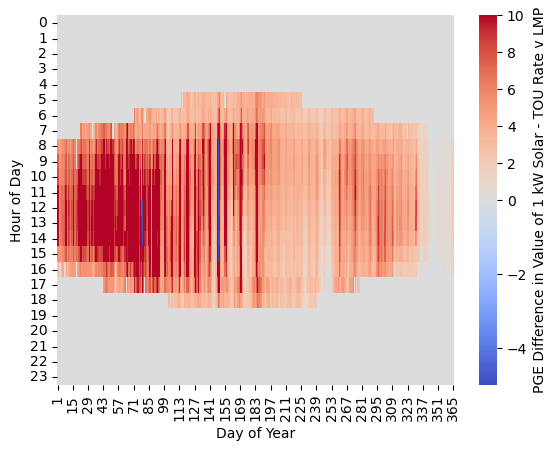

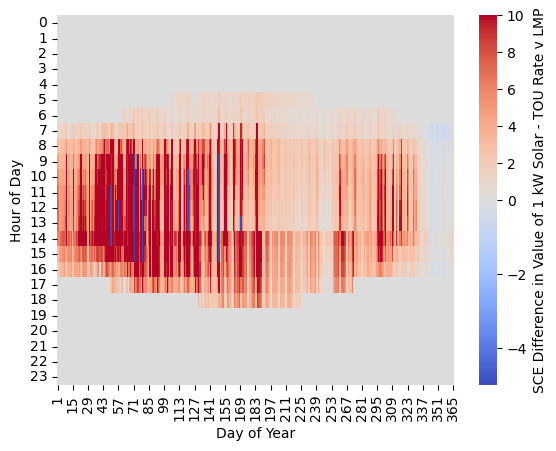

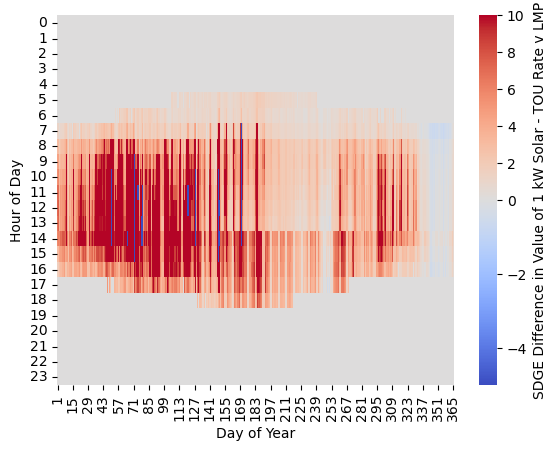

In [242]:
# Set up heat map. 
profiles['Day of Year'] = pd.to_datetime(profiles['Timestamp'], format='%Y-%m-%d %H:%M:%S').dt.dayofyear
profiles['Hour of Day'] = pd.to_datetime(profiles['Timestamp'], format='%Y-%m-%d %H:%M:%S').dt.hour

# For each utility...
for utility in ['PGE', 'SCE', 'SDGE']:

    # Column name. 
    name = f'{utility} Difference in Value of 1 kW Solar - TOU Rate v LMP'

    # Fill NaNs with zeros. 
    profiles[name].fillna(0, inplace=True)

    # Replace infinity with zeros.
    profiles[name].replace(to_replace=np.inf, value=100, inplace=True)

    # Plot percentage difference betwen TOU and LMP valuation for each hour of the year. 
    pivot = profiles.pivot(index='Hour of Day', columns='Day of Year', values=name)
    divnorm=colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=10)
    map = sns.heatmap(pivot, cbar_kws={'label': name'}, cmap='coolwarm', norm=divnorm)
    plt.show()

In [243]:
# Read in annual site valuation data.
df = pd.read_csv('output/Annual_Site_Vals.csv')

In [244]:
df.describe(include='all')

,Utility,NEM Tariff,System Size AC,Normalized Annual Value - Flat Rate,Normalized Annual Value - TOU Rate,Normalized Annual Value - NEM,Normalized Annual Value - LMP,Annual Value - NEM,Annual Value - LMP
count,1500393,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06,1.500393e+06
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,PGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,700084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.642279e+00,6.033560e+00,5.787429e+02,5.016884e+02,5.262168e+02,1.036079e+02,3.166924e+03,6.256080e+02
std,NaN,4.793296e-01,5.141241e+00,1.380971e+02,8.352110e+01,1.110112e+02,4.748729e+00,2.665370e+03,5.285440e+02
min,NaN,1.000000e+00,2.000000e-03,4.098111e+02,4.086583e+02,4.086583e+02,9.747592e+01,1.181219e+00,2.171896e-01
25%,NaN,1.000000e+00,3.779000e+00,4.098111e+02,4.311651e+02,4.098111e+02,1.000884e+02,1.876115e+03,3.883441e+02
50%,NaN,2.000000e+00,5.320000e+00,6.331875e+02,4.311651e+02,5.906093e+02,1.000884e+02,2.737898e+03,5.504862e+02
75%,NaN,2.000000e+00,7.459000e+00,6.331875e+02,5.906093e+02,5.906093e+02,1.085948e+02,3.947633e+03,7.734120e+02


Has investment historically been misallocated?

In [245]:
# There is more solar capacity per customer in PGE's territory than elsewhere.
customers = {'PGE': 5480000, 'SCE': 5070000, 'SDGE': 3700000}
grouped = df[['Utility', 'System Size AC', ]].groupby('Utility', as_index=False).agg({'System Size AC': 'sum'})
grouped['Customers'] = grouped['Utility'].map(customers)
grouped['kW per Customer'] = grouped['System Size AC'] / grouped['Customers']
grouped

,Utility,System Size AC,Customers,kW per Customer
0,PGE,4.295295e+06,5480000,0.783813
1,SCE,3.245091e+06,5070000,0.640057
2,SDGE,1.512325e+06,3700000,0.408737


In [246]:
# This makes sense because the average annual value of systems in the PGE territory 
# is significantly higher than elsewhere under NEM.
grouped = df[['Utility', 'Annual Value - NEM', ]].groupby('Utility', as_index=False).mean()
aav_nem_pge = grouped.loc[grouped['Utility'] == 'PGE', 'Annual Value - NEM'][0]
grouped['Percentage Diff from PGE'] = (grouped['Annual Value - NEM'] - aav_nem_pge)/aav_nem_pge
grouped


,Utility,Annual Value - NEM,Percentage Diff from PGE
0,PGE,3702.137013,0.000000
1,SCE,2536.504228,-0.314854
2,SDGE,3039.321498,-0.179036


In [247]:
# However, the difference in average annual value between PGE and SCE is much smaller when 
# LMPs are used for compensation. 
grouped = df[['Utility', 'Annual Value - LMP', ]].groupby('Utility', as_index=False).mean()
aav_lmp_pge = grouped.loc[grouped['Utility'] == 'PGE', 'Annual Value - LMP'][0]
grouped['Percentage Diff from PGE'] = (grouped['Annual Value - LMP'] - aav_lmp_pge)/aav_lmp_pge
grouped

,Utility,Annual Value - LMP,Percentage Diff from PGE
0,PGE,666.272359,0.000000
1,SCE,599.153923,-0.100737
2,SDGE,570.894827,-0.143151


What happens to the average system when we transition between tariffs?

In [248]:
# Average normalized annual value ($/kWcap/year) for systems on a flat rate.
anav_1_flat = df.loc[df['NEM Tariff'] == 1.0, 'Normalized Annual Value - Flat Rate'].mean()
anav_1_flat

568.8316463047317

In [249]:
# Average normalized annual value ($/kWcap/year) if these systems switched to TOU rate.
anav_1_tou = df.loc[df['NEM Tariff'] == 1.0, 'Normalized Annual Value - TOU Rate'].mean()
anav_1_tou

500.26296839826813

In [250]:
# Percent change in average normalized annual value of switching NEM 1.0 systems to NEM 2.0.
(anav_1_tou - anav_1_flat)/(anav_1_flat)

-0.12054300837849366

In [251]:
# Average normalized annual value ($/kWcap/year) for all systems on an NEM rate.
anav_nem = df['Normalized Annual Value - NEM'].mean()
anav_nem

526.2168476175017

In [252]:
# Average normalized annual value ($/kWcap/year) for all systems on an LMP rate.
anav_lmp = df['Normalized Annual Value - LMP'].mean()
anav_lmp

103.60786886249477

In [253]:
# Percent change in average normalized annual value of switching from systems from current rate to LMPs.
(anav_lmp - anav_nem)/(anav_nem)

-0.8031080355340396

In [254]:
# How much would the average annual value ($/year) change if all customers switched from current rate to LMPs?
aav_nem = df['Annual Value - NEM'].mean()
aav_lmp = df['Annual Value - LMP'].mean()

(aav_lmp - aav_nem)/(aav_nem)

3166.923946005958
625.6080159498489


-0.8024556236221431

In [255]:
df['System Size AC'].mean()

6.033560301952928